In [1]:
import bioframe
import pandas as pd
import numpy as np
import tensorflow as tf
from basenji import dna_io
import akita_utils

import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 13})

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  

2022-10-15 00:04:06.939253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /spack/apps/linux-centos7-x86_64/gcc-8.3.0/python-3.9.2-uvcroioc4witkp6qf7mbebof5ix4wlb6/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/pmix-3.1.3-3sm6emyqaxapunh7rwbjvtaqoqe2e5z3/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openmpi-4.0.2-ipm3dnvlbtxawpi4ifz7jma6jgr7mexq/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openblas-0.3.8-2no6mfziiclwxb7lstxoos335gnhjpes/lib:/spack/apps/gcc/8.3.0/lib64::/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib
2022-10-15 00:04:06.939294: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
folder = "/home1/smaruj/akita_utils/bin/insert_virtual_flanks_experiment/data/"

left_filename = "2022-10-10_flank0-30_200motifs_left.h5"               #orientation "<<"
right_filename = "2022-10-10_flank0-30_200motifs_right.h5"             #orientation ">>"
convergent_filename = "2022-10-10_flank0-30_200motifs_convergent.h5"   #orientation "><"
divergent_filename = "2022-10-10_flank0-30_200motifs_divergent.h5"     #orientation "<>"

scd_stats = ["SCD", "INS-16", "INS-64", "INS-256"]
target_dict = {"0" : "mESC_uC",
              "1" : "mESC",
              "2" : "CN",
              "3" : "ncx_CN",
              "4" : "NPC",
              "5" : "ncx_NPC"} 

In [3]:
left_df = akita_utils.h5_to_df(folder + left_filename, scd_stats, drop_duplicates_key=None)
right_df = akita_utils.h5_to_df(folder + right_filename, scd_stats, drop_duplicates_key=None)
convergent_df = akita_utils.h5_to_df(folder + convergent_filename, scd_stats, drop_duplicates_key=None)
divergent_df = akita_utils.h5_to_df(folder + divergent_filename, scd_stats, drop_duplicates_key=None)

In [4]:
frames = [left_df, right_df, convergent_df, divergent_df]

df = pd.concat(frames)

In [5]:
is_strong = lambda x : True if (x > 20) else False

df["strong"] = df["genomic_SCD"].apply(is_strong)

In [6]:
get_seq_index = lambda x : (x % 200)

df["seq_index"] = df["experiment_id"].apply(get_seq_index)

In [7]:
def average_over_targets(dataframe, stat, mouse=True, model=1):
    
    num_targets = 6
    if not mouse:
        num_targets = 5
    
    collist = [stat + f"_h{int(mouse)}_m{model}_t{i}" for i in range(num_targets)]
    
    dataframe[f"{stat}_average"] = dataframe[collist].mean(axis=1)
    
    return dataframe
    

In [8]:
for stat in ["SCD", "INS-16", "INS-64", "INS-256"]:
    df = average_over_targets(df, stat)

In [9]:
df.groupby(["background_index", "orientation"]).agg({"SCD_average": ["mean", "min", "max"]})

SCD_average                    
                                    mean       min       max
background_index orientation                                
0                <<             49.87500  37.75000  109.1875
                 <>             47.40625  37.40625   94.8125
                 ><             47.71875  37.40625   98.0625
                 >>             45.71875  37.37500   83.1250
1                <<             47.00000  38.75000   92.5000
                 <>             47.00000  38.75000   95.5625
                 ><             46.62500  38.78125   89.1875
                 >>             48.31250  38.81250  101.6875
2                <<             45.18750  38.84375   82.0625
                 <>             44.46875  38.75000   80.0000
                 ><             43.68750  38.84375   75.4375
                 >>             43.81250  38.65625   74.7500

In [10]:
orientation_dict = {
    ">>" : {"strong_label" : "strong_right",
            "weak_label" : "weak_right",
            "line_style" : "-",
            "strong_1color" : "#4dac26",
            "weak_1color" : "#d01c8b"
        },
    "<<" : {"strong_label" : "strong_left",
            "weak_label" : "weak_left",
            "line_style" : "--",
            "strong_1color" : "#2166ac",
            "weak_1color" : "#f03b20"
        },
    "<>" : {"strong_label" : "strong_divergent",
            "weak_label" : "weak_divergent",
            "line_style" : "-.",
            "strong_1color" : "#fc7a02",
            "weak_1color" : "#636363"
        },
    "><" : {"strong_label" : "strong_convergent",
            "weak_label" : "weak_convergent",
            "line_style" : ":",
            "strong_1color" : "#a819dd",
            "weak_1color" : "#000000"
        },
}

In [11]:
orientation_vs_flank = df.groupby(["strong", "orientation", "flank_bp"]).agg({"SCD_average": "mean"}).reset_index()

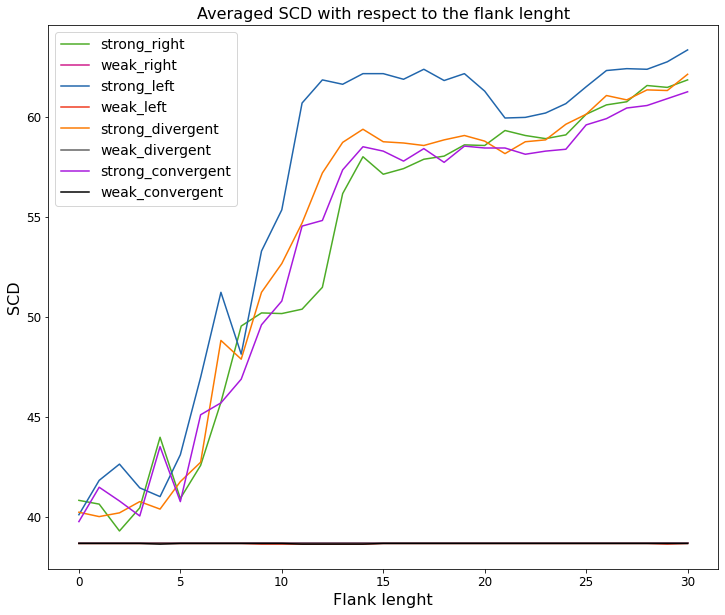

In [12]:
plt.figure(figsize=(12,10))
x = [x for x in range(31)]

for key in orientation_dict:
    plt.plot(x, orientation_vs_flank[(orientation_vs_flank["orientation"] == key) & (orientation_vs_flank["strong"] == True)]["SCD_average"], 
             label=orientation_dict[key]["strong_label"], 
             c=orientation_dict[key]["strong_1color"])
    plt.plot(x, orientation_vs_flank[(orientation_vs_flank["orientation"] == key) & (orientation_vs_flank["strong"] == False)]["SCD_average"], 
             label=orientation_dict[key]["weak_label"], 
             c=orientation_dict[key]["weak_1color"])
    
plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Flank lenght")
plt.ylabel("SCD")
plt.legend(loc="upper left")
# plt.legend(bbox_to_anchor=(1.35, 1.015), loc='upper right', ncol=1)
# plt.savefig("averaged_SCD.png")

### Comment: 
Results are consistent between orientations. There are practically no changes in SCD score in the case of weak CTCF motifs.

In [13]:
orientation_vs_flank_without0 = df[df["background_index"] != 0].groupby(["strong", "orientation", "flank_bp"]).agg({"SCD_average": "mean"}).reset_index()

Since background 0 gives higher SCD score between flank 10 and 20, I plotted averages also without this background.

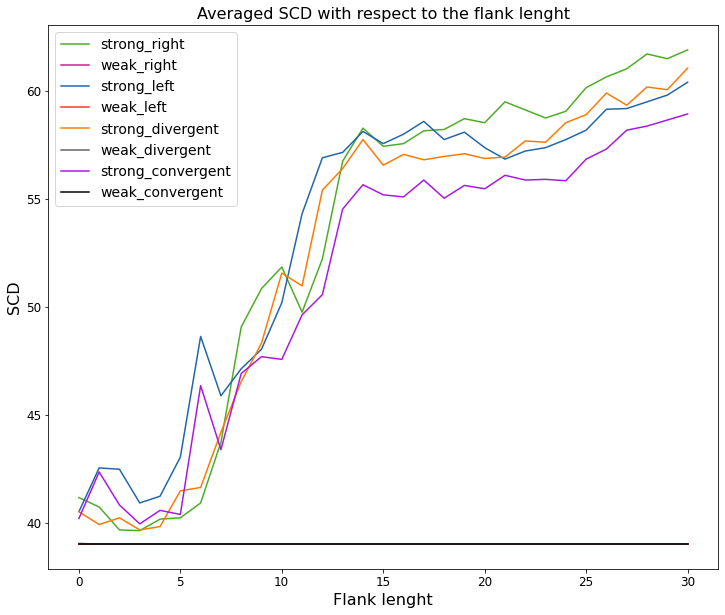

In [14]:
plt.figure(figsize=(12,10))
x = [x for x in range(31)]

for key in orientation_dict:
    plt.plot(x, orientation_vs_flank_without0[(orientation_vs_flank["orientation"] == key) & (orientation_vs_flank["strong"] == True)]["SCD_average"], 
             label=orientation_dict[key]["strong_label"], 
             c=orientation_dict[key]["strong_1color"])
    plt.plot(x, orientation_vs_flank_without0[(orientation_vs_flank["orientation"] == key) & (orientation_vs_flank["strong"] == False)]["SCD_average"], 
             label=orientation_dict[key]["weak_label"], 
             c=orientation_dict[key]["weak_1color"])
    
plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Flank lenght")
plt.ylabel("SCD")
plt.legend(loc="upper left")
# plt.legend(bbox_to_anchor=(1.35, 1.015), loc='upper right', ncol=1)
# plt.savefig("no_bg0_averaged_SCD.png")

### Comment: 
Results are slightly more consistent when the 0-th background is not taken into account. 

In [15]:
background_vs_orientation_vs_flank = df[df["strong"] == True].groupby(["background_index", "orientation", "flank_bp"]).agg({"SCD_average": "mean"}).reset_index()

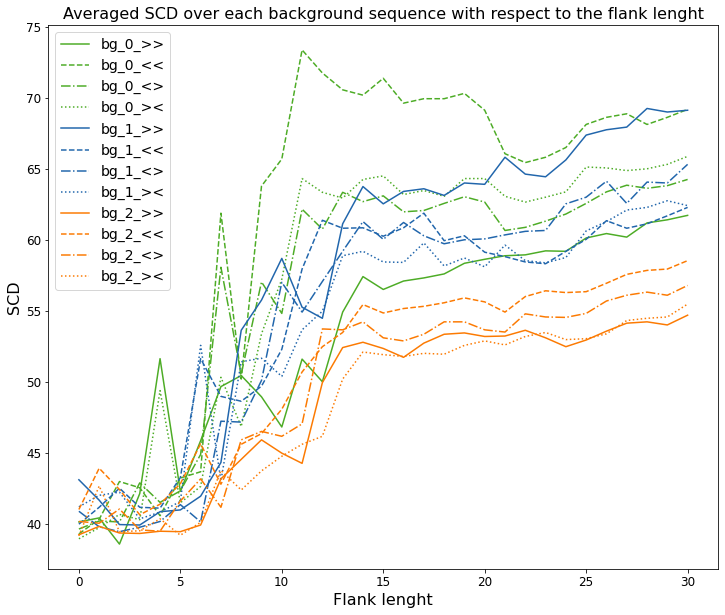

In [16]:
background_colors = ["#4dac26", "#2166ac", "#fc7a02"]

plt.figure(figsize=(12,10))
x = [x for x in range(31)]

for background_idx in [0, 1, 2]:
    for key in orientation_dict:
        plt.plot(x, background_vs_orientation_vs_flank[(background_vs_orientation_vs_flank["background_index"] == background_idx) & (background_vs_orientation_vs_flank["orientation"] == key)]["SCD_average"], 
                 orientation_dict[key]["line_style"],
                 c=background_colors[background_idx],
                 label=f"bg_{background_idx}_{key}")

plt.legend(loc="upper right")
plt.title("Averaged SCD over each background sequence with respect to the flank lenght")
plt.xlabel("Flank lenght")
plt.ylabel("SCD")
plt.legend(loc="upper left")
# plt.legend(bbox_to_anchor=(1.235, 1.015), loc='upper right', ncol=1)
# plt.savefig("backgrounds_SCD.png")

### Comment: 
Tendecies are consistent among background sequences and orientations. 
There are some peaks that overlap - is it caused by inserting into the same background sequence? - Yes, the 0-th background seems to be more "noisy" than others.
I will try different approach with taking a median background score for each sequence.

### Alternative approach -> taking a median over backgrounds

In [17]:
columns_to_take_median = ["INS-16_h1_m1_t0", "INS-16_h1_m1_t1", "INS-16_h1_m1_t2", "INS-16_h1_m1_t3", "INS-16_h1_m1_t4", "INS-16_h1_m1_t5",
                          "INS-256_h1_m1_t0", "INS-256_h1_m1_t1", "INS-256_h1_m1_t2", "INS-256_h1_m1_t3", "INS-256_h1_m1_t4", "INS-256_h1_m1_t5",
                          "INS-64_h1_m1_t0", "INS-64_h1_m1_t1", "INS-64_h1_m1_t2", "INS-64_h1_m1_t3", "INS-64_h1_m1_t4", "INS-64_h1_m1_t5", 
                          "SCD_h1_m1_t0", "SCD_h1_m1_t1", "SCD_h1_m1_t2", "SCD_h1_m1_t3", "SCD_h1_m1_t4", "SCD_h1_m1_t5",
                          "SCD_average", "INS-16_average", "INS-64_average", "INS-256_average"]
median_list = ["median" for i in range(len(columns_to_take_median))]

dictionary_to_median = dict(zip(columns_to_take_median, median_list))

In [18]:
new_df = df.groupby(["strong", "orientation","flank_bp", "seq_index"]).agg(dictionary_to_median).reset_index()

In [19]:
new_orientation_vs_flank = new_df.groupby(["strong", "orientation", "flank_bp"]).agg({"SCD_average": "mean"}).reset_index()

In [20]:
from cooltools.lib import numutils

In [24]:
bin_size = 19

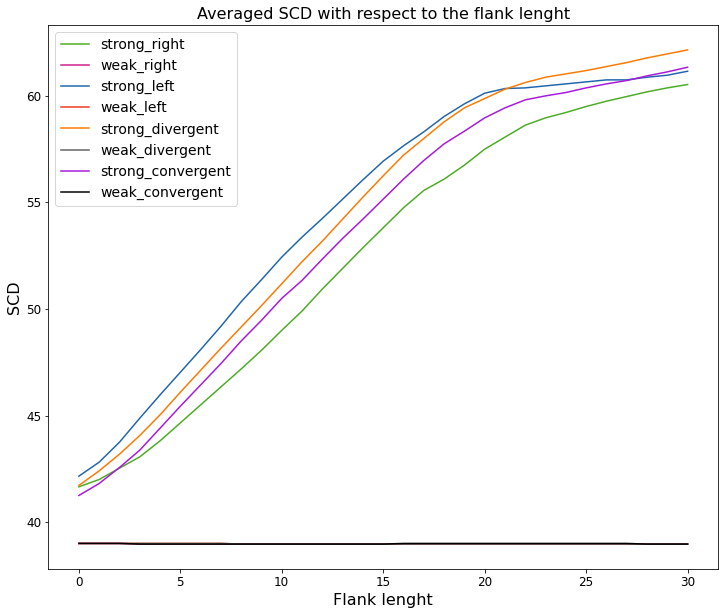

In [25]:
plt.figure(figsize=(12,10))
x = [x for x in range(31)]

for key in orientation_dict:
    plt.plot(x, numutils.smooth(new_orientation_vs_flank[(new_orientation_vs_flank["orientation"] == key) & (new_orientation_vs_flank["strong"] == True)]["SCD_average"], bin_size), 
             label=orientation_dict[key]["strong_label"], 
             c=orientation_dict[key]["strong_1color"])
    plt.plot(x, numutils.smooth(new_orientation_vs_flank[(new_orientation_vs_flank["orientation"] == key) & (new_orientation_vs_flank["strong"] == False)]["SCD_average"], bin_size), 
             label=orientation_dict[key]["weak_label"], 
             c=orientation_dict[key]["weak_1color"])
    
plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Flank lenght")
plt.ylabel("SCD")
plt.legend(loc="upper left")
# plt.legend(bbox_to_anchor=(1.35, 1.015), loc='upper right', ncol=1)
# plt.savefig("median_SCD_bin19.png")

In [26]:
strong_targets = ["#F20808", "#1119EF", "#09DAE9", "#13F238", "#EC9018", "#E80ACA"]
weak_targets = ["#E65A5A", "#7B7EDB", "#AAEAEF", "#98F0A7", "#EEBE80", "#E69FDD"]

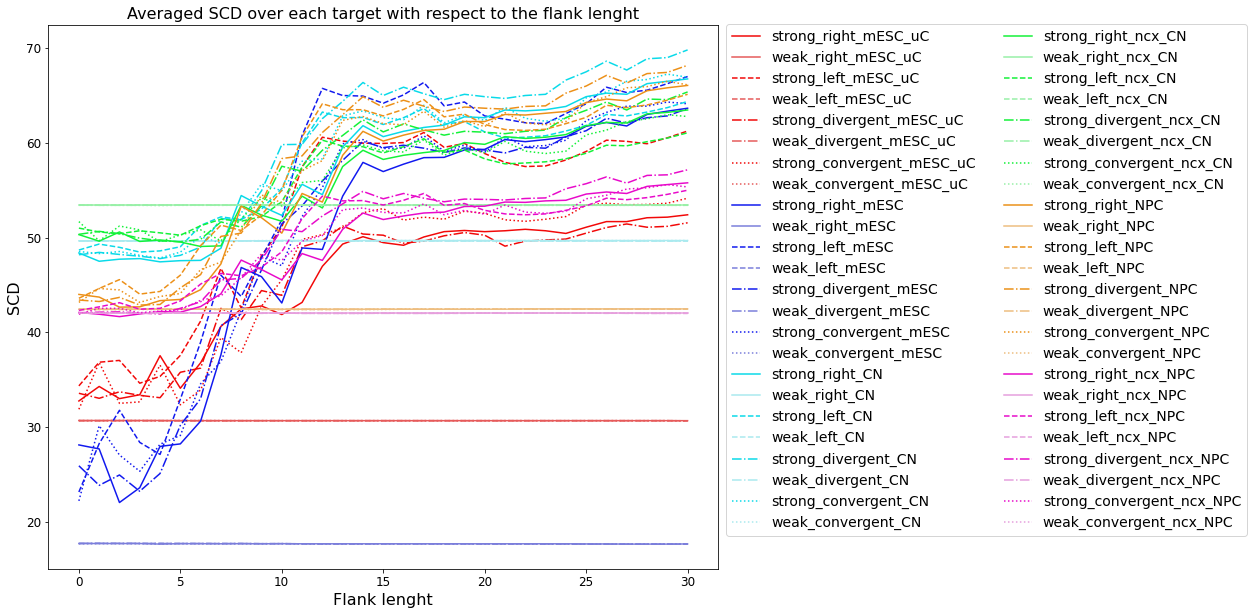

In [56]:
plt.figure(figsize=(12,10))
x = [x for x in range(31)]

for target_idx in range(6):
    target_vs_orientation_flank = new_df.groupby(["strong", "orientation", "flank_bp"]).agg({f"SCD_h1_m1_t{target_idx}": "mean"}).reset_index()
    for key in orientation_dict:
        plt.plot(x, target_vs_orientation_flank[(target_vs_orientation_flank["orientation"] == key) & (target_vs_orientation_flank["strong"] == True)][f"SCD_h1_m1_t{target_idx}"],
                 orientation_dict[key]["line_style"],
                 label=orientation_dict[key]["strong_label"] + f"_{target_dict[str(target_idx)]}", 
                 c=strong_targets[target_idx])
        plt.plot(x, target_vs_orientation_flank[(target_vs_orientation_flank["orientation"] == key) & (target_vs_orientation_flank["strong"] == False)][f"SCD_h1_m1_t{target_idx}"],
                 orientation_dict[key]["line_style"],
                 label=orientation_dict[key]["weak_label"] + f"_{target_dict[str(target_idx)]}", 
                 c=weak_targets[target_idx])
    
plt.title("Averaged SCD over each target with respect to the flank lenght")
plt.xlabel("Flank lenght")
plt.ylabel("SCD")
# plt.legend(loc="upper left")
plt.legend(bbox_to_anchor=(1.80, 1.015), loc="upper right", ncol=2)
plt.savefig("targets_SCD.png", bbox_inches="tight")
# plt.savefig("targets_SCD.png")

## orientation_vs_flank_sequence

In [30]:
orientation_vs_flank_sequence = new_df[new_df["strong"] == True].groupby(["orientation", "seq_index", "flank_bp"]).agg({"SCD_average": "mean"}).reset_index()

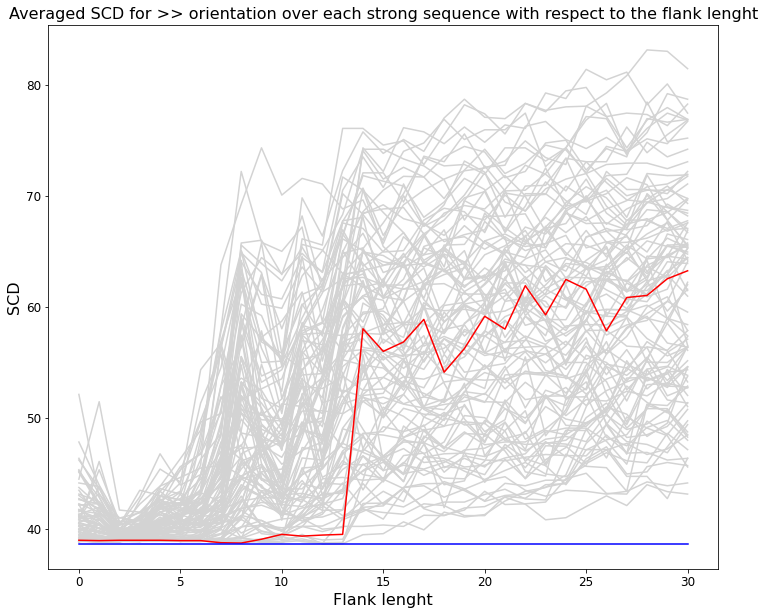

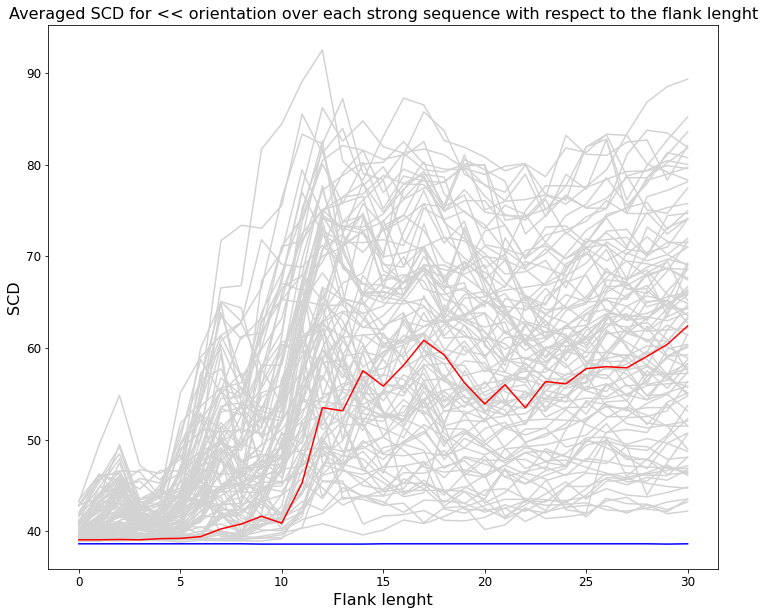

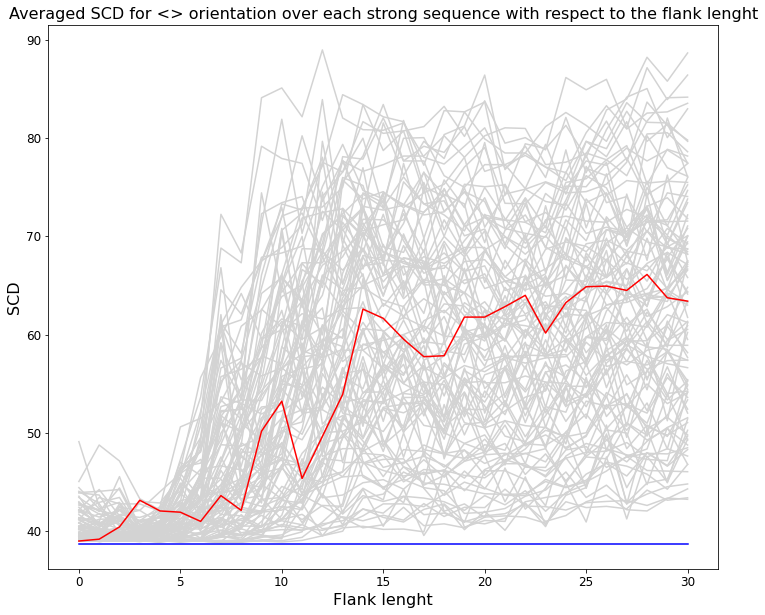

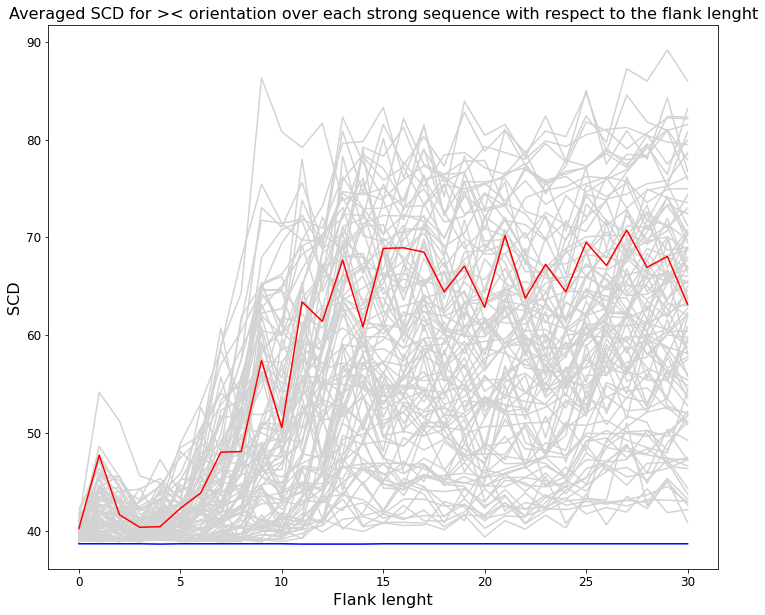

In [31]:
for key in orientation_dict:
    helper_df = orientation_vs_flank_sequence[(orientation_vs_flank_sequence["orientation"] == key) & (orientation_vs_flank_sequence["flank_bp"] == 30)]
    median_seq_idx = helper_df.loc[helper_df["SCD_average"] > helper_df["SCD_average"].median()].sort_values(by=["SCD_average"]).iloc[0]["seq_index"]
    
    orient = orientation_vs_flank_sequence[orientation_vs_flank_sequence["orientation"] == key]
    
    plt.figure(figsize=(12,10))
    x = [x for x in range(31)]

    for seq_idx in range(100):

        if seq_idx != median_seq_idx:
            plt.plot(x, orient[orient["seq_index"] == seq_idx]["SCD_average"], c="lightgray")

    plt.plot(x, orient[orient["seq_index"] == median_seq_idx]["SCD_average"], c="red")
    
    # blue line is average over all weak sequences
    plt.plot(x, orientation_vs_flank[(orientation_vs_flank["orientation"] == key) & (orientation_vs_flank["strong"] == False)]["SCD_average"], 
             c="blue")
    
    plt.title(f"Averaged SCD for {key} orientation over each strong sequence with respect to the flank lenght")
    plt.xlabel("Flank lenght")
    plt.ylabel("SCD")
    # plt.savefig(f"sequences_SCD_{key}.png")

In [32]:
import seaborn as sns

In [33]:
x_half_orientation_dict = {
    "orientation" : [],
    "x_halves" : []
}

In [34]:
for key in orientation_dict:
    
    for seq_id in range(100):
        helper_df = orientation_vs_flank_sequence[(orientation_vs_flank_sequence["orientation"] == key) & (orientation_vs_flank_sequence["seq_index"] == seq_id)]
        
        max_SCD = float(helper_df["SCD_average"].max())
        flank_max_SCD = int(list(helper_df.loc[helper_df["SCD_average"] == max_SCD]["flank_bp"])[-1])
        
        f_x_half = helper_df["SCD_average"].min() + (0.5 * (helper_df["SCD_average"].max() - helper_df["SCD_average"].min()))
        bellow_mid_part = helper_df.loc[helper_df["SCD_average"] < f_x_half].sort_values(by=["SCD_average"], ascending=False)
        
        for index in range(len(bellow_mid_part)):
            if bellow_mid_part["flank_bp"].iloc[index] <= flank_max_SCD:
                x_half = bellow_mid_part["flank_bp"].iloc[index]
                break
            else:
                continue

        x_half_orientation_dict["orientation"].append(key)
        x_half_orientation_dict["x_halves"].append(x_half)

In [35]:
x_half_orientation_df = pd.DataFrame.from_dict(data = x_half_orientation_dict)

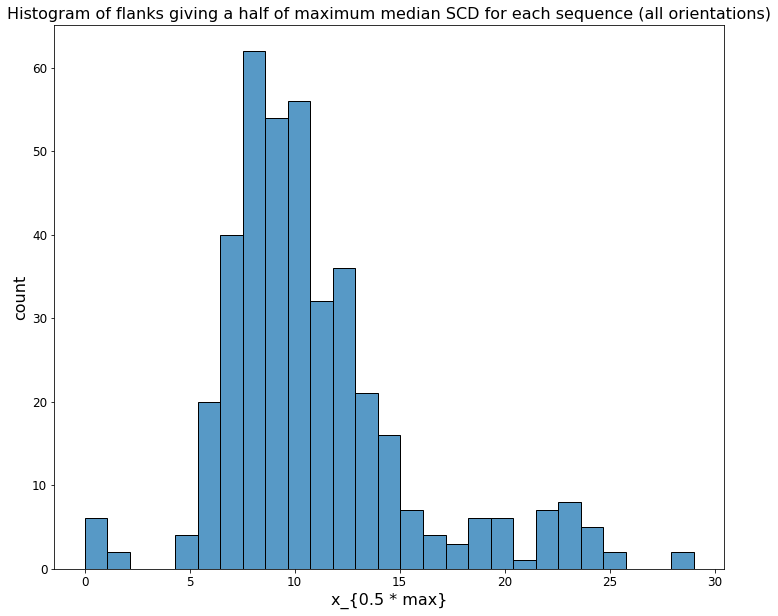

In [57]:
plt.figure(figsize=(12,10))
sns.histplot(data=x_half_orientation_df, x="x_halves")
plt.title(f"Histogram of flanks giving a half of maximum median SCD for each sequence (all orientations)")
plt.xlabel("x_{0.5 * max}")
plt.ylabel("count")
# plt.savefig("histogram1.png")

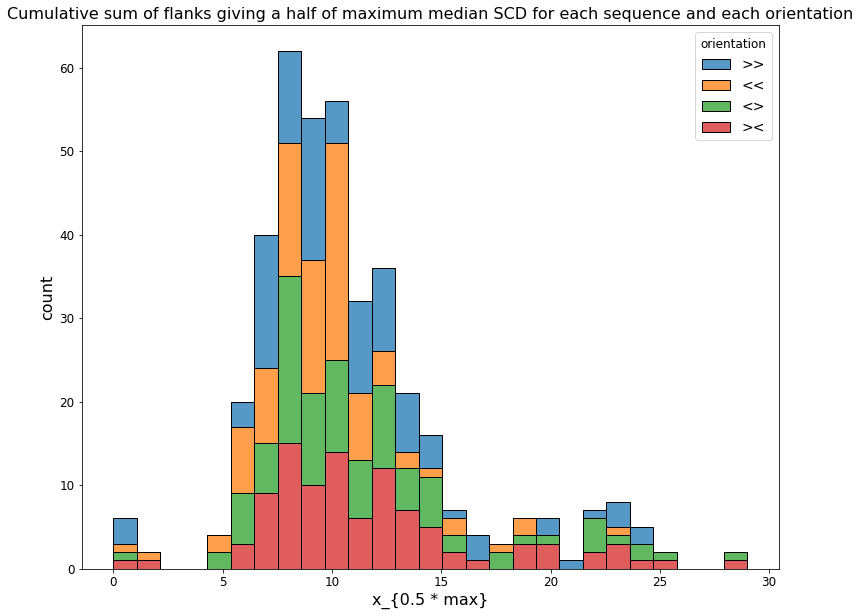

In [58]:
plt.figure(figsize=(12.5,10))
sns.histplot(data=x_half_orientation_df, x="x_halves", hue="orientation", multiple="stack")
plt.title(f"Cumulative sum of flanks giving a half of maximum median SCD for each sequence and each orientation")
plt.xlabel("x_{0.5 * max}")
plt.ylabel("count")
# plt.savefig("histogram2.png")

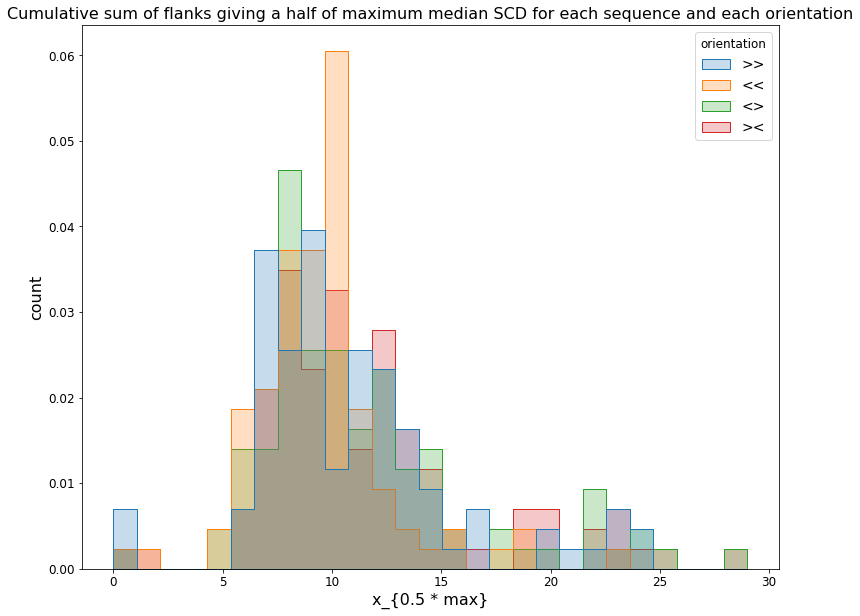

In [38]:
plt.figure(figsize=(12.5,10))
sns.histplot(data=x_half_orientation_df, x="x_halves", hue="orientation", element="step", stat="density")
plt.title(f"Cumulative sum of flanks giving a half of maximum median SCD for each sequence and each orientation")
plt.xlabel("x_{0.5 * max}")
plt.ylabel("count")
# plt.savefig("histogram3.png")

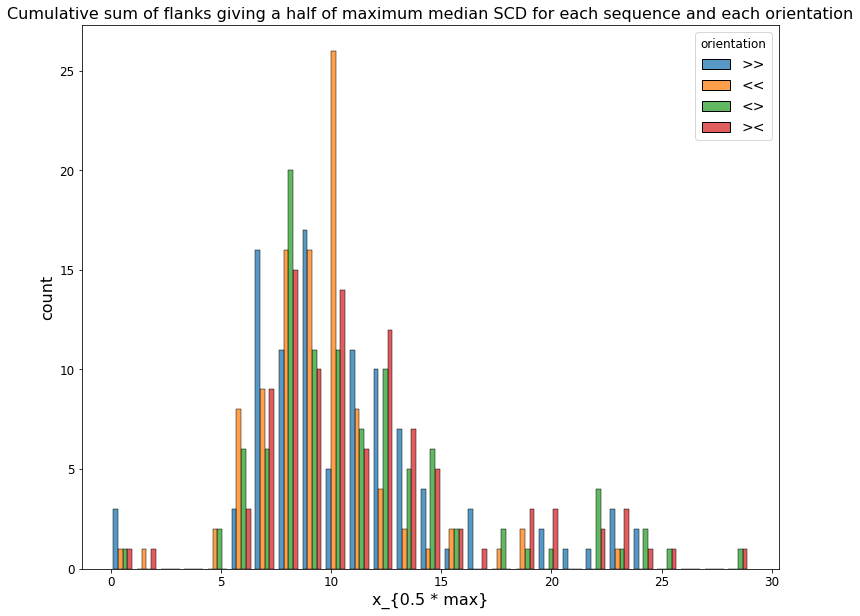

In [39]:
plt.figure(figsize=(12.5,10))
sns.histplot(data=x_half_orientation_df, x="x_halves", hue="orientation", multiple="dodge", shrink=.8)
plt.title(f"Cumulative sum of flanks giving a half of maximum median SCD for each sequence and each orientation")
plt.xlabel("x_{0.5 * max}")
plt.ylabel("count")
# plt.savefig("histogram4.png")

Text(0, 0.5, 'density')

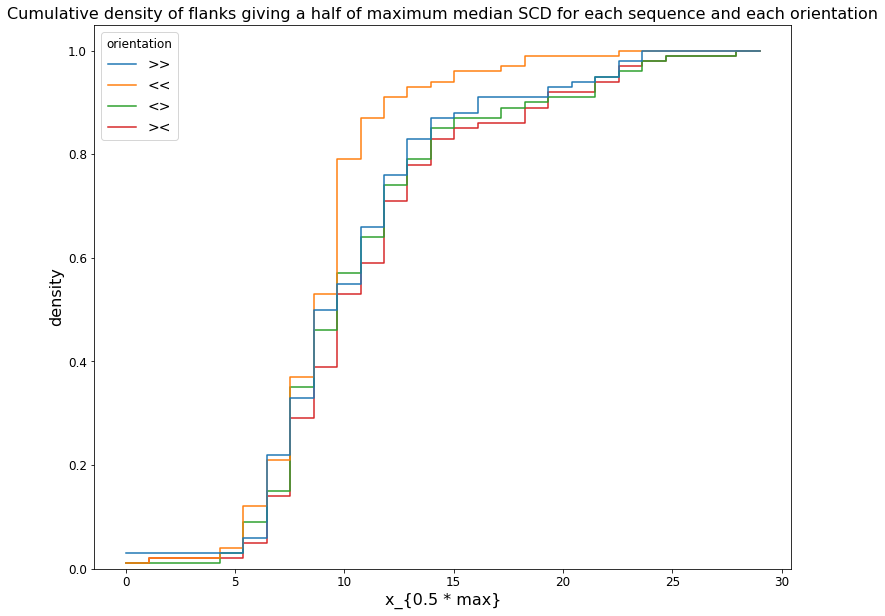

In [61]:
plt.figure(figsize=(12.5,10))
sns.histplot(
    data=x_half_orientation_df, x="x_halves", hue="orientation",
    element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
)
plt.title(f"Cumulative density of flanks giving a half of maximum median SCD for each sequence and each orientation")
plt.xlabel("x_{0.5 * max}")
plt.ylabel("density")
# plt.savefig("histogram5_step.png")

Text(0, 0.5, 'density')

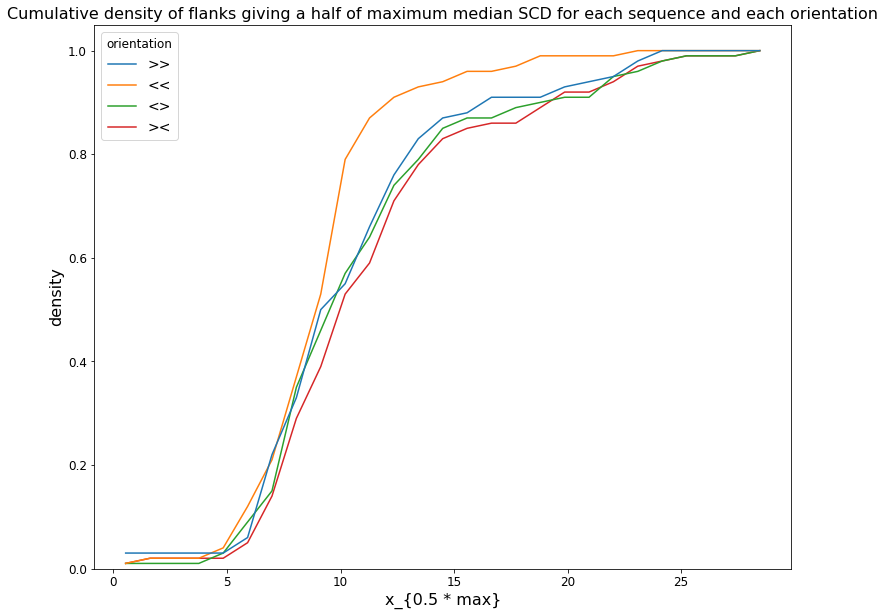

In [62]:
plt.figure(figsize=(12.5,10))
sns.histplot(
    data=x_half_orientation_df, x="x_halves", hue="orientation",
    element="poly", fill=False,
    cumulative=True, stat="density", common_norm=False,
)
plt.title(f"Cumulative density of flanks giving a half of maximum median SCD for each sequence and each orientation")
plt.xlabel("x_{0.5 * max}")
plt.ylabel("density")
# plt.savefig("histogram5_poly.png")

In [41]:
scaled_x_half_orientation_dict = {
    "orientation" : [],
    "scaled_x_halves" : []
}

In [42]:
for key in orientation_dict:
    
    for seq_id in range(100):
        helper_df = orientation_vs_flank_sequence[(orientation_vs_flank_sequence["orientation"] == key) & (orientation_vs_flank_sequence["seq_index"] == seq_id)]
        
        max_SCD = float(helper_df["SCD_average"].max())
        flank_max_SCD = int(list(helper_df.loc[helper_df["SCD_average"] == max_SCD]["flank_bp"])[-1])
        
        f_x_half = helper_df["SCD_average"].min() + (0.5 * (helper_df["SCD_average"].max() - helper_df["SCD_average"].min()))
        bellow_mid_part = helper_df.loc[helper_df["SCD_average"] < f_x_half].sort_values(by=["SCD_average"], ascending=False)
        
        for index in range(len(bellow_mid_part)):
            if bellow_mid_part["flank_bp"].iloc[index] <= flank_max_SCD:
                x_half = bellow_mid_part["flank_bp"].iloc[index]
                break
            else:
                continue

        scaled_x_half_orientation_dict["orientation"].append(key)
        scaled_x_half_orientation_dict["scaled_x_halves"].append((x_half / flank_max_SCD))


In [43]:
scaled_x_half_orientation_df = pd.DataFrame.from_dict(data = scaled_x_half_orientation_dict)

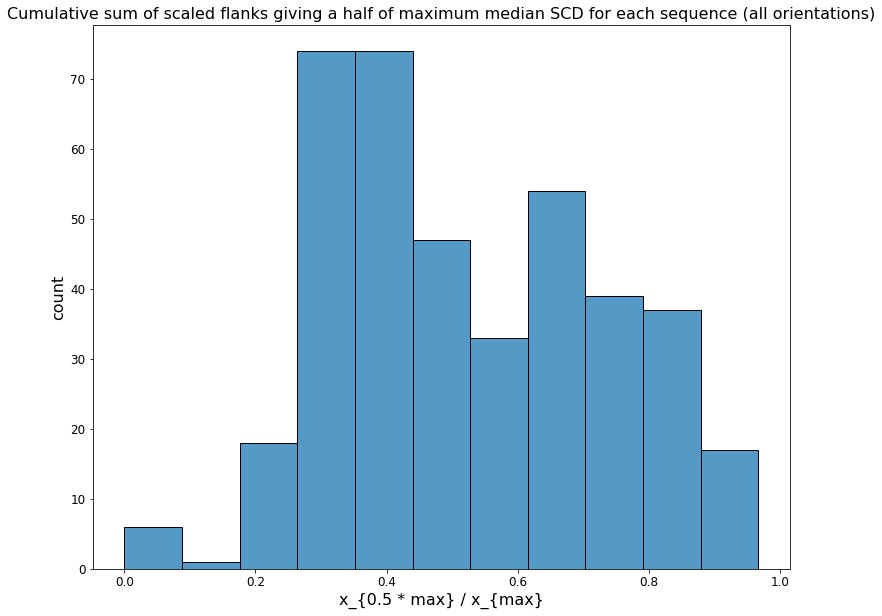

In [44]:
plt.figure(figsize=(12.5,10))
sns.histplot(data=scaled_x_half_orientation_df, x="scaled_x_halves")
plt.title(f"Cumulative sum of scaled flanks giving a half of maximum median SCD for each sequence (all orientations)")
plt.xlabel("x_{0.5 * max} / x_{max}")
plt.ylabel("count")
# plt.savefig("histogram6.png")

In [45]:
orientation_vs_SCD = new_df[new_df["strong"] == True].groupby(["orientation", "flank_bp"]).agg({"SCD_average": "mean"}).reset_index()

In [46]:
all_orientations_sum = pd.DataFrame(orientation_vs_SCD.groupby(["flank_bp"]).agg({"SCD_average": "sum"})["SCD_average"])

In [47]:
orientation_vs_SCD = orientation_vs_SCD.merge(all_orientations_sum, how = "left", on="flank_bp", suffixes=('_orient', '_sum'))

In [48]:
orientation_vs_SCD["orient_ratio"] = orientation_vs_SCD["SCD_average_orient"] / orientation_vs_SCD["SCD_average_sum"]

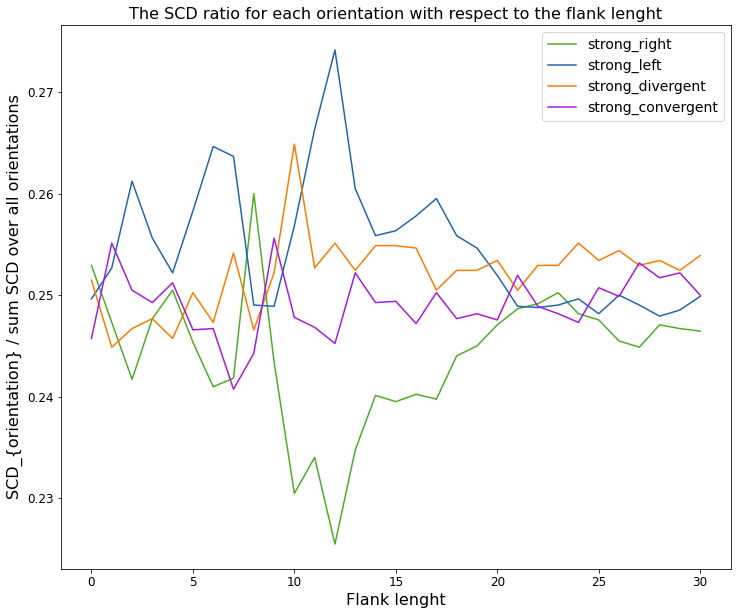

In [50]:
plt.figure(figsize=(12,10))
x = [x for x in range(31)]

for key in orientation_dict:
    plt.plot(x, orientation_vs_SCD[orientation_vs_SCD["orientation"] == key]["orient_ratio"], 
             label=orientation_dict[key]["strong_label"], 
             c=orientation_dict[key]["strong_1color"])

plt.title("The SCD ratio for each orientation with respect to the flank lenght")
plt.xlabel("Flank lenght")
plt.ylabel("SCD_{orientation} / sum SCD over all orientations")
plt.legend(loc="upper right")
# plt.legend(bbox_to_anchor=(1.35, 1.015), loc='upper right', ncol=1)
# plt.savefig("SCD_ratio.png")